# MC Dropout as Bayesian Approximation Notebook

Goal: A complete workflow with prototypical functions that I'll be using for all the other workflows.

Some of the workflow will be taken from my code from Statistical NLP module.
* Ideally it's not too difficult to swap things like the dropout regime, training schedule etc
* Need to have a training manager that saves and logs data
* Better way to define UNet - also possibly easy to switch out other networks would be nice

10th June: Complete notebook sketch

# Installs & Imports

In [ ]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch import ones_like, zeros_like
from torchsummary import summary
from tqdm.notebook import tqdm

# Detect GPU and set as default device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {DEVICE}')

Using cuda:0


## Import dataset

Currently I import from google drive to keep the flexibility of able to import eval set here as well.
If I just need training set we could use git clone to get the zip file.

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

# copy dataset to local env
if 'mastr' not in os.listdir():
  !cp "/content/drive/My Drive/project_online/dataset/mastr.zip" .
  !unzip -q 'mastr.zip' -d mastr
  !rm 'mastr.zip'


Mounted at /content/drive/


# Process Data

### Define some global variables

In [ ]:
# Global variables
NUM_CLASSES = 3
CLASS_MAP = {0: 'obstacle', 1: 'ground', 2: 'sky', 3: 'ambiguous', 4: 'remove'} # 3 and 4 should not be fed into the network
SEED = 0

# dummy pixel (placed at boundaries), we want to change it from 4 to 3, then drop it in the end
DROP_PIX = 4
FILL_PIX = 3

TRAINING_PATH = '/content/mastr/'
IMAGE_DIR = TRAINING_PATH + 'images/'
LABEL_DIR = TRAINING_PATH + 'masks/'

## Dataset Definition

Two definitions for dataset:
* `OnlineDataset` doesn't store the processed images and reads them from the drive's local folder, used for evaluation dataset
* `MemoryDataset` loads all the images into memory. This only works for the training set which is relatively small.

In [ ]:
class OnlineDataset(Dataset):
    def __init__(self, x_dir, y_dir, transform=None):
        '''
        Online dataset that takes directories as inputs and loads the images

        Args
        ------
        x_dir : str, directory holding images (e.g. /content/mastr/images)
        y_dir : str, directory holding labels (e.g. /content/mastr/masks)
        transforms : transforms.Compose([...])
        '''
        self.y_dir = y_dir
        self.x_dir = x_dir
        self.transform = transform

        # This list is used to index all the images in the directory
        # image and labels share same prefix in the names
        self.x_file_names = os.listdir(x_dir)

    def __len__(self):
        return len(os.listdir(self.x_dir))

    def __getitem__(self, idx):
        # get image and label path
        x_path = os.path.join(self.x_dir, self.x_file_names[idx])
        # TODO: can refactor this if other dataset are used
        y_path = os.path.join(
            self.y_dir, self.x_file_names[idx].replace(".jpg", "m.png"))

        x = read_image(x_path)
        y = read_image(y_path)

        # NOTE: image format(C, W, H)

        if self.transform:
            x, y = self.transform((x, y))

        return x, y

class MemoryDataset(Dataset):
    def __init__(self, X, y, transform=None):
        '''
        Loads dataset from memory

        Args
        ------
        X : Tensor with shape (n, 3, 384, 512)
        y : Tensor with shape (n, 1, 384, 512)
        transforms : transforms.Compose([...])
        '''
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform:
            x, y = self.transform((x, y))
        return x, y

## Transformation
All the transformations are performed using `torchvision.transforms` or `transforms.functional`.
* `HFlip`: Horizontal flip
* `HueSatCon`: Brightness, contrast, saturation, and hue (always applied)
* `Affine`: Translation and Shear
* `Rotation`: Rotate
* `Crop`
* `Resize`

The transformations should be performed in the order above, the goal is to emulate scenes similar to shoreline images, thus ordering matters. E.g. Horizontal shear followed by rotate is preferred compared to the other way around.

In [ ]:
# Flip, Hue & sat, Rotation, Scaling, Resize, Normalize

# Only on tensors!
class HFlip(object):
    def __init__(self, prob=0.5):
        self.flip_transform = transforms.RandomHorizontalFlip(1)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          x = self.flip_transform(x)
          y = self.flip_transform(y)

        return (x, y)

class HueSatCon(object):
    def __init__(self, brightness, contrast, saturation, hue, prob=1):
        self.hue_transform = transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob and x!= None:
            x = self.hue_transform(x)
        return (x, y)

class Rotation(object):
    def __init__(self, angle, prob=1):
        self.angle = angle
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          # comptute random angle to rotate for this instance
          rot_angle = (random.random()*2-1) * self.angle
          x = transforms.functional.rotate(x, rot_angle, expand=False)
          y = transforms.functional.rotate(y, rot_angle, expand=False, fill=FILL_PIX)
        return (x, y)

class Crop(object):
    def __init__(self, crop_percentage, prob=1):
        self.crop_percentage = crop_percentage
        self.prob = prob

    def __call__(self, data):
        (x, y) = data
        p = random.random()
        if p < self.prob:
          # compute random crop proportions for this instance
          dim1 = x.shape[1] # horizontal length
          dim2 = x.shape[2] # vertical length
          # percentage crop in the horizontal direction
          crop1 = random.random()*(1-self.crop_percentage) + self.crop_percentage
          # percentage crop in the vertical direction
          crop2 = random.random()*(1-self.crop_percentage) + self.crop_percentage
          # compute all the arguments for TF.crop()
          width = int(crop1 * dim2)
          height = int(crop2 * dim1)
          left = int(random.random() * ((1-crop1)/2) * dim1)
          top = int(random.random() * ((1-crop2)/2) * dim2)

          x = transforms.functional.crop(x, top, left, height, width)
          y = transforms.functional.crop(y, top, left, height, width)

        return (x, y)

# Translation and Shear
class Affine(object):
    def __init__(self, affine_percentage, shear_deg, prob=1):
        self.affine_percentage = affine_percentage # (e.g. 0.1)
        self.shear_deg = shear_deg # in deg (e.g. 15)
        self.prob = prob

    def __call__(self, data):
        (x, y) = data

        p = random.random()
        if p < self.prob:
          # compute random affine proportions for this instance
          dim1 = x.shape[1] # horizontal length
          dim2 = x.shape[2] # vertical length

          # translation offset for this instance
          offset1 = (random.random() * 2 - 1) * dim1 * self.affine_percentage
          offset2 = (random.random() * 2 - 1) * dim2 * self.affine_percentage
          # shear deg for this instance
          shear = (random.random() * 2 - 1) * self.shear_deg

          # apply affine transformation
          x = torchvision.transforms.functional.affine(x, angle = 0, translate = [offset1, offset2], shear=[shear, 0], scale=1,
                                                       interpolation = transforms.InterpolationMode.BILINEAR)
          y = torchvision.transforms.functional.affine(y, angle = 0, translate = [offset1, offset2], shear=[shear, 0], scale=1,
                                                       interpolation = transforms.InterpolationMode.NEAREST, fill=FILL_PIX)
        return (x, y)

class Resize(object):
    def __init__(self, size):
        self.size = size
        self.resize_x = transforms.Resize(size, transforms.InterpolationMode.BILINEAR, antialias=True)
        self.resize_y = transforms.Resize(size, transforms.InterpolationMode.NEAREST, antialias=True) #nearest-exact?

    def __call__(self, data):
        x, y = data
        x = self.resize_x(x)
        y = self.resize_y(y)

        return (x, y)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, move_to_device=True):
        self.to_tensor = transforms.PILToTensor()
        self.move = move_to_device

    def __call__(self, data):
        x, y = data

        x = self.to_tensor(x)
        y = self.to_tensor(y)

        if self.move:
          x = x.to(DEVICE)
          y = y.to(DEVICE)

        # Normalize - TODO
        # x = x / 255.0

        imageNet_normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        x = imageNet_normalize(x)
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

        return (x, y)

class Normalize(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        # imageNet Normalize
        self.Normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    def __call__(self, data):
        x, y = data
        x = self.Normalize(x)
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

        return (x, y)

## Train-val split

In [ ]:
def train_val_test_split(X, y, train_ratio, val_ratio):
  '''
  splits the dataset into train and validation sets
  '''
  torch.manual_seed(SEED) # !important

  n = X.shape[0]

  perm = torch.randperm(n)

  tr_ratio = train_ratio / (train_ratio+val_ratio)
  v_ratio = val_ratio / (train_ratio+val_ratio)

  tr_n = int(tr_ratio * n)
  val_n = int(v_ratio * n)

  X_train, y_train = X[perm[:tr_n]], y[perm[:tr_n]]
  X_val, y_val = X[perm[tr_n:]], y[perm[tr_n:]]

  return X_train, y_train, X_val, y_val

## Load MaSTr1325
Load entire training set into memory and create dataset objects

In [ ]:
# load all of training data into memory
def load_mastr(img_dir, mask_dir):
    '''Load all data into memory '''
    img_file_names = os.listdir(img_dir)
    n = len(img_file_names)
    # preallocate tensor memory
    X = torch.zeros((n, 3, 384, 512), dtype=torch.float32, device=DEVICE, requires_grad=False)
    Y = torch.zeros((n, 1, 384, 512), dtype=torch.float32, device=DEVICE, requires_grad=False)

    for i in tqdm(range(n)):
      img_path = os.path.join(img_dir, img_file_names[i])
      mask_path = os.path.join(
          mask_dir, img_file_names[i].replace(".jpg", "m.png"))

      x = read_image(img_path)
      y = read_image(mask_path)

      x = x / 255.0
      y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

      X[i] = x
      Y[i] = y

    return X, Y

In [ ]:
X_train_raw, y_train_raw, X_val_raw, y_val_raw = None, None, None, None
X_raw, y_raw = load_mastr(IMAGE_DIR, LABEL_DIR)
print(f'Number of total images: {len(X_raw)}')

  0%|          | 0/1325 [00:00<?, ?it/s]

Number of total images: 1325


### Split dataset

Number of training images: 1225
Number of validation images: 100


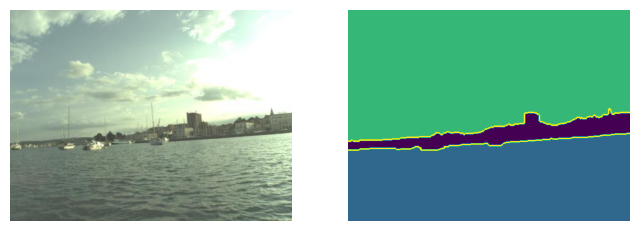

In [ ]:
X_train_raw, y_train_raw, X_val_raw, y_val_raw = train_val_test_split(X_raw, y_raw, 1225, 100)
print(f'Number of training images: {len(X_train_raw)}')
print(f'Number of validation images: {len(X_val_raw)}')

# show sample image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train_raw[0].permute(1, 2, 0).cpu())
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y_train_raw[0].permute(1, 2, 0).cpu())
plt.axis('off')

del X_raw, y_raw

### Dataset objects



In [ ]:
# define transformations
train_transforms = transforms.Compose([
    HFlip(prob=0.5),
    HueSatCon(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, prob=1),
    Affine(affine_percentage=0.1, shear_deg=5, prob=1),
    Rotation(10, prob=1),
    Crop(crop_percentage=0.9, prob=1),
    Resize((224, 224)),
    Normalize(),
])

val_transforms = transforms.Compose([
    Resize((224, 224)),
    Normalize(),
])

In [ ]:
train_dataset = MemoryDataset(X_train_raw, y_train_raw, train_transforms)
val_dataset = MemoryDataset(X_val_raw, y_val_raw, val_transforms)

## DataLoader Definition

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': None}

### Preview example images

These are images that will be fed into the network

In [ ]:
def unnormalize(image: torch.tensor) -> torch.tensor:
  '''
  Reverses imageNet Normalization to [0, 1], (for visualization purposes)
  '''
  mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]
  std = [1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]
  reverse_normalize = transforms.Normalize(mean, std)

  return torch.clip(reverse_normalize(image), 0, 1)

In [ ]:
# x_batch_sample, y_batch_sample = next(iter(train_dataloader))

# plt.figure(figsize=(8, 3))
# for i in range(3):
#   plt.subplot(1, 6, i*2+1)
#   plt.imshow(unnormalize(x_batch_sample[i]).permute(1, 2, 0).cpu())
#   plt.axis('off')
#   plt.subplot(1, 6, i*2+2)
#   plt.imshow(y_batch_sample[i].permute(1, 2, 0).cpu())
#   plt.axis('off')

# # note: clipping error message can be ignored
# plt.tight_layout()


# # VALIDATION IMAGES
# plt.figure(figsize=(8, 3))
# for i in range(3):
#   x, y = next(iter(val_dataloader))
#   plt.subplot(1, 6, i*2+1)
#   x = unnormalize(x[0])
#   plt.imshow(x.permute(1, 2, 0).cpu())
#   plt.axis('off')
#   plt.subplot(1, 6, i*2+2)
#   plt.imshow(y[0].permute(1, 2, 0).cpu())
#   plt.axis('off')

# plt.tight_layout()

# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric

## UNet

In [ ]:
class Unet_MobileNetV2(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        # attaches hooks to the encoder
        # self.feature_extractor = Encoder_feature_extractor(self.encoder)

        # dummy forward pass to load decoder
        dummy_input = torch.rand((2, 3, 224, 224))
        self.decoder.load(self.encoder(dummy_input))

        assert(self.decoder.loaded==True)

        # freeze encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.encoder(x)
        out = self.decoder(features)
        return out

    def toggle_dropout(self, dropout_state):
        self.encoder.toggle_dropout(dropout_state)
        self.decoder.toggle_dropout(dropout_state)

    def update_dropout_config(self, encoder_config, decoder_config):
        self.encoder.update_dropout_config(encoder_config)
        self.decoder.update_dropout_config(decoder_config)


### Encoder

In [ ]:
class Unet_MobileNetV2_Encoder(nn.Module):
    def __init__(self, pretrained_net, dropout_config=None):
        '''
        Args
        ---------
        pretrained_net: nn.Module, pretrained mobileNet
        dropout_config: dict
        '''
        super().__init__()
        self.net = copy.deepcopy(pretrained_net)

        self._load()

        self.dropout_state = True
        if dropout_config is None:
          self.dropout_config = {
              'skip_1': 0.0,
              'skip_2': 0.0,
              'skip_3': 0.0,
              'skip_4': 0.5,
              'skip_5': 0.5,
          }

    def _load(self):
        '''
        Attaches feature extractor to the encoder
        '''
        self.feature_extractor = Encoder_feature_extractor(self.net)

    def toggle_dropout(self, dropout_state):
        self.dropout_state = dropout_state

    def update_dropout_config(self, dropout_config):
        self.dropout_config = dropout_config

    def forward(self, x):
        out = self.net(x)

        features = self.feature_extractor.features

        if self.dropout_state == True:
          for k, v in features.items():
            d = nn.Dropout(p=self.dropout_config[k])
            features[k] = d(features[k])

        return features

### Decoder

In [264]:
# Conv2DTranspose => Batchnorm => Dropout => Relu
class Unet_MobileNetV2_Decoder(nn.Module):
    def __init__(self, dropout_config=None):
        super().__init__()
        self.loaded = False
        if dropout_config is None:
          dropout_config = [0.5, 0.5, 0.5, 0.5]

        self.dropout_state = True
        self.dropout_config = dropout_config

    def load(self, encoder_features):
        '''
        initiates the decoder layers based on encoder inputs
        '''
        # TODO (optional): refactor the decoder blocks for arbitrary encoder features

        deconv_outputs = [512, 256, 128, 64, 3]
        # print(encoder_features.features)

        in_channels = encoder_features['skip_5'].shape[1]

        self.block_1 = self.deconv_block(in_channels, deconv_outputs[0], 3, 2, self.dropout_config[0])
        in_channels = deconv_outputs[0] + encoder_features['skip_4'].shape[1]

        self.block_2 = self.deconv_block(in_channels, deconv_outputs[1], 3, 2, self.dropout_config[1])
        in_channels = deconv_outputs[1] + encoder_features['skip_3'].shape[1]

        self.block_3 = self.deconv_block(in_channels, deconv_outputs[2], 3, 2, self.dropout_config[2])
        in_channels = deconv_outputs[2] + encoder_features['skip_2'].shape[1]

        self.block_4 = self.deconv_block(in_channels, deconv_outputs[3], 3, 2, self.dropout_config[3])
        in_channels = deconv_outputs[3] + encoder_features['skip_1'].shape[1]

        self.final_layer = nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.softmax = nn.LogSoftmax(dim=1)

        self.loaded = True

    def deconv_block(self, in_channels, out_channels, kernel_size, stride, dropout=0.5):
        conv_transpose_2d = nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1)
        torch.nn.init.xavier_normal_(conv_transpose_2d.weight)
        return nn.Sequential(
            conv_transpose_2d,
            nn.BatchNorm2d(num_features=out_channels),
            nn.Dropout(p=dropout),
            nn.ReLU()
        )

    def toggle_dropout(self, dropout_state: bool):
        self.dropout_state = dropout_state

    def update_dropout_config(self, dropout_config: list):
        self.dropout_config = dropout_config

    def forward(self, input):
        assert(self.loaded==True)

        # overwrite unet train/eval state for the dropout layers
        if self.dropout_state == True:
          for m in self.modules():
            if m.__class__.__name__.startswith('Dropout'):
              m.train()
          self.block_1[2].p = self.dropout_config[0]
          self.block_2[2].p = self.dropout_config[1]
          self.block_3[2].p = self.dropout_config[2]
          self.block_4[2].p = self.dropout_config[3]

        x = input['skip_5']
        x = self.block_1(x)
        x = torch.cat((x, input['skip_4']), dim=1)
        x = self.block_2(x)
        x = torch.cat((x, input['skip_3']), dim=1)
        x = self.block_3(x)
        x = torch.cat((x, input['skip_2']), dim=1)
        x = self.block_4(x)
        x = torch.cat((x, input['skip_1']), dim=1)
        x = self.final_layer(x)
        x = self.softmax(x)

        return x

### Feature Extractor

In [ ]:
class Encoder_feature_extractor():
    def __init__(self, encoder):
        self.features = {}

        layers = {
            "skip_1": encoder.features[2].conv[0][2],
            "skip_2": encoder.features[4].conv[0][2],
            "skip_3": encoder.features[7].conv[0][2],
            "skip_4": encoder.features[14].conv[0][2],
            "skip_5": encoder.features[17]
        }

        for (name, layer) in layers.items():
            layer.register_forward_hook(self._get_feature(name))

    def _get_feature(self, name):
        def hook(model, input, output):
            self.features[name] = output
        return hook

### MobileNetV2

Remove last two layers

In [178]:
mobileNetWeights = torchvision.models.MobileNet_V2_Weights
mobileNet = torchvision.models.mobilenet_v2(weights=mobileNetWeights)

# remove unused layers
mobileNet.features[-1] = nn.Identity()
mobileNet.classifier = nn.Identity()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Initiate Network

This is just to preview the network, usually the network is initiated within the training manager.

In [179]:
encoder = Unet_MobileNetV2_Encoder(mobileNet)
decoder = Unet_MobileNetV2_Decoder()
unet = Unet_MobileNetV2(encoder, decoder)

# move network to GPU
unet.to(DEVICE)
print(f'Network is on {next(unet.parameters()).device}')

Network is on cuda:0


In [180]:
# Set dropout config
encoder_dropout_config = {'skip_1': 0.0, 'skip_2': 0.0, 'skip_3': 0.0, 'skip_4': 0.5, 'skip_5': 0.5 }
decoder_dropout_config = [0.5, 0.5, 0, 0]

unet.toggle_dropout(False)
unet.update_dropout_config(encoder_dropout_config, decoder_dropout_config)

### Dummy pass to see initial outputs

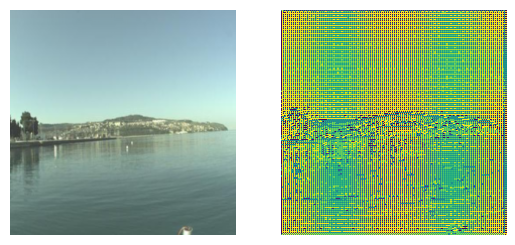

In [184]:
x_batch_sample, y_batch_sample = next(iter(val_dataloader))

with torch.no_grad():
  unet.eval()
  plt.subplot(1, 2, 1)
  plt.imshow(unnormalize(x_batch_sample[0]).permute(1, 2, 0).cpu())
  plt.axis('off')

  pred = unet(x_batch_sample.to(DEVICE))
  plt.subplot(1, 2, 2)
  plt.imshow(torch.argmax(pred[0], dim=0).cpu().detach().numpy())
  plt.axis('off')
  unet.train()

In [185]:
pred.shape

torch.Size([1, 3, 224, 224])

## Loss

In [309]:
class FocalLoss(object):
  def __init__(self):
    self.CE_loss = torch.nn.CrossEntropyLoss(ignore_index=3, reduction='mean')
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, 3, 224, 224)
    '''
    loss = self.CE_loss(y_pred, y_true.squeeze(dim=1).long())
    # # place mask over placeholder pixels (loss do not propagate through them)
    # mask = torch.where(y_true == 3.0, zeros_like(y_true), ones_like(y_true))

    # y_true = (y_true * mask).squeeze(dim=1)
    # # one-hot encode labels
    # y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=3).float().permute(0, 3, 1, 2)

    # y_pred = y_pred * mask
    # focal_loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='none')
    # loss = (focal_loss * mask).sum() / mask.sum()

    return loss


## Metric

In [ ]:
# TODO: DICE accuracy

In [ ]:
class AccuracyMetric(object):
  def __init__(self):
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, 3, 224, 224)
    '''
    # select most probable class
    y_pred = torch.argmax(y_pred, 1, keepdim=True) # TODO: do I need sigmoid in front of this?
    mask = torch.where(y_true == 3, zeros_like(y_true), ones_like(y_true))

    # correct pixels
    diff = torch.where(y_pred == y_true, ones_like(y_true), zeros_like(y_true))
    # filter
    diff = accuracy = diff.sum() / mask.sum()

    return accuracy


## Bayes Forward

In [340]:
def bayes_forward(net, X:torch.tensor, k:int):
  '''
  Performs k forward passes with dropout layers, returns mean and std

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (3 x 224 x 224), a single input image
  k  : int, indicating number of repeated forwards passes

  Returns
  -----------
  y_softmax            : torch.tensor (3 x 224 x 224)
  y_pred               : torch.tensor (224 x 224)
  y_pred_std_per_class : torch.tensor (3 x 224 x 224)
  y_pred_std_avg       : torch.tensor (224 x 224)
  '''
  with torch.no_grad():
      net.eval()
      X_repeat = X.unsqueeze(0).repeat(k, 1, 1, 1)
      y_pred_raw = net(X_repeat)

  net.train()

  # Average the softmax
  y_softmax = y_pred_raw.mean(dim=0) # (3 x 224 x 224)
  # Take max prob as prediction
  y_pred = torch.argmax(y_softmax, dim=0).to(torch.int) # (224 x 224)
  # Per class uncertainty
  y_pred_std_per_class = y_pred_raw.exp().std(dim=0) # (3 x 224 x 224)
  # Average uncertainty over classes
  y_pred_std_avg = y_pred_std_per_class.mean(dim=0) # (224 x 224)

  return y_softmax, y_pred, y_pred_std_per_class, y_pred_std_avg

# Training Manager

This is the class responsible handling training, evaluation, recording values during training, etc.

In [266]:
class TrainingManager():
  def __init__(self, dataloaders, config, net=None, ):
    self.dataloaders = dataloaders

    # hyperparameters from config
    self.weight_decay = config['weight_decay']
    self.lr = config['lr']
    self.k = config['k']
    self.encoder_dropout_config = config['encoder_dropout_config']
    self.decoder_dropout_config = config['decoder_dropout_config']

    if not net:
      encoder = Unet_MobileNetV2_Encoder(copy.deepcopy(mobileNet))
      decoder = Unet_MobileNetV2_Decoder(decoder_dropout_config)
      self.net = Unet_MobileNetV2(encoder, decoder).to(DEVICE)
      # dropout parameters
      self.net.toggle_dropout(True)
      self.net.update_dropout_config(encoder_dropout_config, decoder_dropout_config)
    else:
      self.net = copy.deepcopy(net).to(DEVICE)

    self.criterion = FocalLoss()
    self.metric = AccuracyMetric()

    self.optimizer = torch.optim.RMSprop(self.net.parameters(), weight_decay=self.weight_decay, lr=self.lr)

    self.epoch = 0
    self.history = {
        'loss/train': [],
        'loss/val': [],
        'loss/val_b': [],
        'loss/test': [],
        'acc/train': [],
        'acc/val': [],
        'acc/val_b': [],
        'acc/test': [],
    }

  def train(self, epochs, eval_mode='bayes'):
    torch.cuda.empty_cache() # helps clearing RAM
    self.net.train()
    self.net.toggle_dropout(True)

    for e in range(epochs):
      train_loss_epoch = 0
      train_acc_epoch = 0

      for X_batch, y_batch in tqdm(self.dataloaders['train']):
        self.optimizer.zero_grad()

        # forward pss
        y_pred = self.net(X_batch)

        # compute loss
        loss = self.criterion(y_batch, y_pred)
        acc = self.metric(y_batch, y_pred)

        # back prop
        loss.backward()

        # update parameters
        self.optimizer.step()

        # log batch loss and accuracy
        batch_size = X_batch.shape[0]
        train_loss_epoch += loss * batch_size
        train_acc_epoch += acc * batch_size

      # log epoch loss and accuracy
      n_train = len(self.dataloaders['train'].dataset)
      self.history['loss/train'].append(train_loss_epoch/n_train)
      self.history['acc/train'].append(train_acc_epoch/n_train)

      # run network on validation set
      if eval_mode == 'all':
        val_loss, val_acc, val_loss_b, val_acc_b = self.evaluate('val', eval_mode)
        self.history['loss/val'].append(val_loss)
        self.history['acc/val'].append(val_acc)
        self.history['loss/val_b'].append(val_loss_b)
        self.history['acc/val_b'].append(val_acc_b)
      else:
        val_loss, val_acc = self.evaluate('val', eval_mode)
        self.history['loss/val'].append(val_loss)
        self.history['acc/val'].append(val_acc)
        self.history['loss/val_b'].append(0)
        self.history['acc/val_b'].append(0)

      self.epoch += 1

      print(f'Epoch {self.epoch}')
      print(f"Loss: train = {self.history['loss/train'][-1]:.4f}, val = {self.history['loss/val'][-1]:.4f}")
      print(f"Acc: train = {self.history['acc/train'][-1]*100:.4f}, val = {self.history['acc/val'][-1]*100:.4f}")
      if eval_mode == 'all':
        print(f"Bayes_validation: loss = {self.history['loss/val_b'][-1]:.4f}, acc = {self.history['acc/val_b'][-1]*100:.4f}")

  def _evaluate_regular(self, dataloader):
    self.net.eval()
    self.net.toggle_dropout(False)
    total_loss, total_acc = 0, 0
    with torch.no_grad():
      for X, y in dataloader:
        # forward pss
        y_pred = self.net(X)
        # compute loss & acc
        loss = self.criterion(y, y_pred)
        acc = self.metric(y, y_pred)
        total_loss += loss * len(X)
        total_acc += acc * len(X)

    n = len(dataloader.dataset)
    return total_loss/n, total_acc/n

  def _evaluate_bayes(self, dataloader, k=None):
    if k == None:
      k = self.k

    self.net.toggle_dropout(True)
    self.net.update_dropout_config(self.encoder_dropout_config,
                                   self.decoder_dropout_config)

    total_loss, total_acc = 0, 0
    # force loop to be over single images:
    for X_batch, y_batch in dataloader:
      for (x, y) in zip(X_batch, y_batch):
        # bayes forward pass
        y_pred, _, _, _ = bayes_forward(self.net, x, k)
        y_pred = y_pred.unsqueeze(0)
        y = y.unsqueeze(0)
        # compute loss & acc
        loss = self.criterion(y, y_pred)
        acc = self.metric(y, y_pred)

        total_loss += loss
        total_acc += acc
    n = len(dataloader.dataset)
    return total_loss/n, total_acc/n

  def evaluate(self, eval_dataset='val', mode='bayes'):
    assert (eval_dataset in ['val', 'test', 'train'])
    assert (mode in ['regular', 'bayes', 'all'])

    if mode == 'regular':
      loss, acc = self._evaluate_regular(self.dataloaders[eval_dataset])
    elif mode == 'bayes':
      loss, acc = self._evaluate_bayes(self.dataloaders[eval_dataset])
    elif mode == 'all':
       # TODO: if this is mode used often it should be refactored
      loss, acc = self._evaluate_regular(self.dataloaders[eval_dataset])
      loss_b, acc_b = self._evaluate_bayes(self.dataloaders[eval_dataset])
      return loss, acc, loss_b, acc_b

    return loss, acc

  def plot(self, save=False):
    '''
    Plots training history
    '''
    plt.figure(figsize=(8, 4))

    history = {k: [i.cpu().detach() for i in v] for (k, v) in self.history.items()}

    x = list(range(1, self.epoch+1, 1))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(x, history['loss/train'], label='train',)
    plt.plot(x, history['loss/val'], label='val')
    plt.plot(x, history['loss/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(x, history['acc/train'], label='train',)
    plt.plot(x, history['acc/val'], label='val')
    plt.plot(x, history['acc/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.show()

    if save:
      # TODO
      pass

    return

  def plot_acc_vs_k(self, ks=[5, 10, 15, 20, 25, 30, 35, 40], dataloader=None,):
    '''
    plots accuracy vs k
    '''
    if dataloader is None:
      dataloader = self.dataloaders['val']

    # evaluate bayesian forward for different ks
    losses, accs = [], []
    print('evaluating...')
    for k in tqdm(ks):
      loss, acc = self._evaluate_bayes(dataloader, k)
      losses.append(loss.cpu().detach())
      accs.append(acc.cpu().detach())

      print(f'{k}: {loss}, {acc}')

    # weight averaging (i.e. regular)
    loss, acc = self._evaluate_regular(dataloader)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title('loss')
    plt.plot(ks, losses, label='Bayes')
    plt.plot(ks, [loss.cpu().detach()]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Acc')
    plt.plot(ks, accs, label='Bayes')
    plt.plot(ks, [acc.cpu().detach()]*len(ks), label='WA')
    plt.legend()

    return

  def _save_model(self, ):
    pass

  def _save_logs(self, ):
    pass

  def save(self, ):
    pass




# Result Summary

This class summarises training stats across many runs and has a plotting function to show the results

# Experiments Section

### Baseline

In [300]:
torch.cuda.empty_cache()

In [268]:
config = {
    'lr': 1e-4,
    'weight_decay': 1e-5,
    'k' : 10,
    'encoder_dropout_config' : {'skip_1': 0.0, 'skip_2': 0.0, 'skip_3': 0.0, 'skip_4': 0.5, 'skip_5': 0.5 },
    'decoder_dropout_config' : [0.5, 0.5, 0, 0]
}

training_manager = TrainingManager(dataloaders, config)

evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

5: 0.04776280000805855, 0.9915273189544678
10: 0.04782569408416748, 0.9915060997009277
15: 0.047718346118927, 0.9916281700134277
20: 0.04777945578098297, 0.9915749430656433
25: 0.047771576792001724, 0.9916498064994812
30: 0.04768747836351395, 0.9916703701019287
35: 0.047701261937618256, 0.9917216300964355
40: 0.04770253971219063, 0.9917297959327698


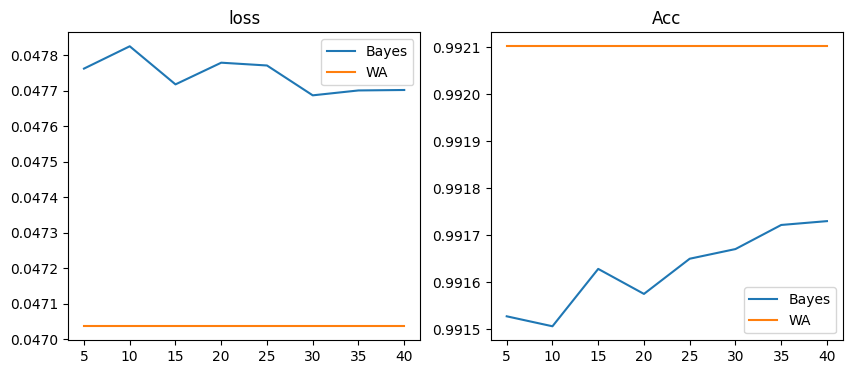

In [285]:
# training_manager.evaluate(mode='all')
training_manager.plot_acc_vs_k()

In [280]:
training_manager.train(epochs=20, eval_mode='all')

  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 21
Loss: train = 0.0505, val = 0.0479
Acc: train = 98.5560, val = 99.0302
Bayes_validation: loss = 0.0489, acc = 98.9752


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 22
Loss: train = 0.0505, val = 0.0478
Acc: train = 98.5552, val = 99.0751
Bayes_validation: loss = 0.0489, acc = 98.9747


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 23
Loss: train = 0.0502, val = 0.0476
Acc: train = 98.6230, val = 99.0960
Bayes_validation: loss = 0.0484, acc = 99.0707


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 24
Loss: train = 0.0501, val = 0.0477
Acc: train = 98.6363, val = 99.0907
Bayes_validation: loss = 0.0488, acc = 98.9794


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 25
Loss: train = 0.0499, val = 0.0478
Acc: train = 98.6731, val = 99.0701
Bayes_validation: loss = 0.0487, acc = 99.0211


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 26
Loss: train = 0.0499, val = 0.0478
Acc: train = 98.6721, val = 99.0267
Bayes_validation: loss = 0.0486, acc = 98.9896


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 27
Loss: train = 0.0497, val = 0.0473
Acc: train = 98.7138, val = 99.1561
Bayes_validation: loss = 0.0482, acc = 99.0961


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 28
Loss: train = 0.0495, val = 0.0474
Acc: train = 98.7422, val = 99.1334
Bayes_validation: loss = 0.0482, acc = 99.0837


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 29
Loss: train = 0.0495, val = 0.0474
Acc: train = 98.7551, val = 99.1610
Bayes_validation: loss = 0.0481, acc = 99.1114


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 30
Loss: train = 0.0494, val = 0.0473
Acc: train = 98.7699, val = 99.1653
Bayes_validation: loss = 0.0481, acc = 99.0935


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 31
Loss: train = 0.0492, val = 0.0472
Acc: train = 98.8267, val = 99.1760
Bayes_validation: loss = 0.0480, acc = 99.1237


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 32
Loss: train = 0.0492, val = 0.0473
Acc: train = 98.8160, val = 99.1786
Bayes_validation: loss = 0.0480, acc = 99.1057


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 33
Loss: train = 0.0491, val = 0.0474
Acc: train = 98.8131, val = 99.1496
Bayes_validation: loss = 0.0481, acc = 99.0849


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 34
Loss: train = 0.0489, val = 0.0470
Acc: train = 98.8637, val = 99.2055
Bayes_validation: loss = 0.0477, acc = 99.1617


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 35
Loss: train = 0.0490, val = 0.0470
Acc: train = 98.8573, val = 99.2154
Bayes_validation: loss = 0.0478, acc = 99.1569


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 36
Loss: train = 0.0489, val = 0.0470
Acc: train = 98.8648, val = 99.2198
Bayes_validation: loss = 0.0477, acc = 99.1630


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 37
Loss: train = 0.0486, val = 0.0470
Acc: train = 98.9279, val = 99.2336
Bayes_validation: loss = 0.0476, acc = 99.1918


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 38
Loss: train = 0.0486, val = 0.0473
Acc: train = 98.9130, val = 99.1610
Bayes_validation: loss = 0.0484, acc = 99.0538


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 39
Loss: train = 0.0486, val = 0.0471
Acc: train = 98.9285, val = 99.2116
Bayes_validation: loss = 0.0477, acc = 99.1661


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 40
Loss: train = 0.0486, val = 0.0470
Acc: train = 98.9257, val = 99.2102
Bayes_validation: loss = 0.0477, acc = 99.1636


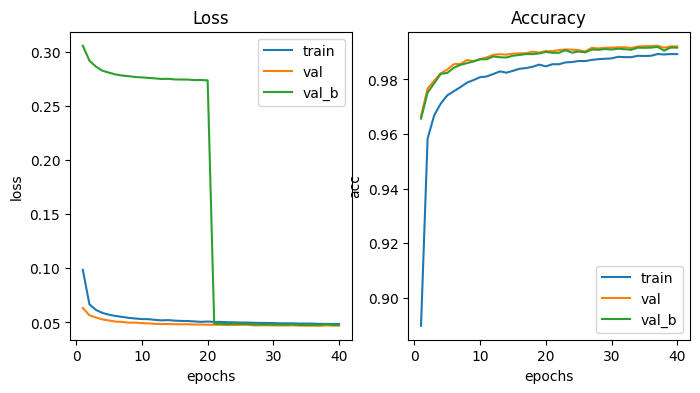

In [281]:
training_manager.plot()

In [ ]:
training_manager.net.update_dropout_config(
    {'skip_1': 0.0, 'skip_2': 0.0, 'skip_3': 0.0, 'skip_4': 0.5, 'skip_5': 0.5},
    [0.5, 0.5, 0.0, 0.0]
)
training_manager.net.encoder.dropout_config

{'skip_1': 0.0, 'skip_2': 0.0, 'skip_3': 0.0, 'skip_4': 0.5, 'skip_5': 0.5}

### Less dropout

In [286]:
config = {
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'k' : 10,
    'encoder_dropout_config' : {'skip_1': 0.0, 'skip_2': 0.0, 'skip_3': 0.0, 'skip_4': 0.5, 'skip_5': 0.5 },
    'decoder_dropout_config' : [0.5, 0, 0, 0]
}

training_manager2 = TrainingManager(dataloaders, config)

In [287]:
training_manager2.train(epochs=20, eval_mode='all')

  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 1
Loss: train = 0.1077, val = 0.0681
Acc: train = 87.4650, val = 96.1319
Bayes_validation: loss = 0.0690, acc = 96.6886


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 2
Loss: train = 0.0670, val = 0.0590
Acc: train = 96.1770, val = 97.4635
Bayes_validation: loss = 0.0606, acc = 97.6580


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 3
Loss: train = 0.0608, val = 0.0557
Acc: train = 97.0529, val = 97.9004
Bayes_validation: loss = 0.0567, acc = 98.0430


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 4
Loss: train = 0.0579, val = 0.0532
Acc: train = 97.4479, val = 98.2144
Bayes_validation: loss = 0.0543, acc = 98.2901


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 5
Loss: train = 0.0562, val = 0.0565
Acc: train = 97.6645, val = 97.4549
Bayes_validation: loss = 0.0575, acc = 97.4445


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 6
Loss: train = 0.0551, val = 0.0506
Acc: train = 97.8244, val = 98.6003
Bayes_validation: loss = 0.0523, acc = 98.4760


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 7
Loss: train = 0.0542, val = 0.0515
Acc: train = 97.9299, val = 98.4255
Bayes_validation: loss = 0.0524, acc = 98.4265


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 8
Loss: train = 0.0535, val = 0.0496
Acc: train = 98.0413, val = 98.7464
Bayes_validation: loss = 0.0510, acc = 98.6506


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 9
Loss: train = 0.0527, val = 0.0493
Acc: train = 98.1662, val = 98.7876
Bayes_validation: loss = 0.0504, acc = 98.7516


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 10
Loss: train = 0.0521, val = 0.0489
Acc: train = 98.2936, val = 98.8606
Bayes_validation: loss = 0.0503, acc = 98.7585


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 11
Loss: train = 0.0517, val = 0.0488
Acc: train = 98.3518, val = 98.8924
Bayes_validation: loss = 0.0500, acc = 98.7990


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 12
Loss: train = 0.0515, val = 0.0486
Acc: train = 98.3765, val = 98.9260
Bayes_validation: loss = 0.0501, acc = 98.7947


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 13
Loss: train = 0.0510, val = 0.0487
Acc: train = 98.4685, val = 98.8994
Bayes_validation: loss = 0.0497, acc = 98.8783


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 14
Loss: train = 0.0509, val = 0.0480
Acc: train = 98.4770, val = 99.0376
Bayes_validation: loss = 0.0491, acc = 98.9441


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 15
Loss: train = 0.0506, val = 0.0487
Acc: train = 98.5510, val = 98.8780
Bayes_validation: loss = 0.0500, acc = 98.7747


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 16
Loss: train = 0.0505, val = 0.0480
Acc: train = 98.5661, val = 99.0176
Bayes_validation: loss = 0.0486, acc = 99.0070


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 17
Loss: train = 0.0505, val = 0.0484
Acc: train = 98.5777, val = 98.9821
Bayes_validation: loss = 0.0498, acc = 98.8280


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 18
Loss: train = 0.0504, val = 0.0484
Acc: train = 98.5733, val = 98.9130
Bayes_validation: loss = 0.0491, acc = 98.8868


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 19
Loss: train = 0.0498, val = 0.0476
Acc: train = 98.6915, val = 99.1116
Bayes_validation: loss = 0.0484, acc = 99.0504


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 20
Loss: train = 0.0498, val = 0.0476
Acc: train = 98.7085, val = 99.1174
Bayes_validation: loss = 0.0483, acc = 99.0835


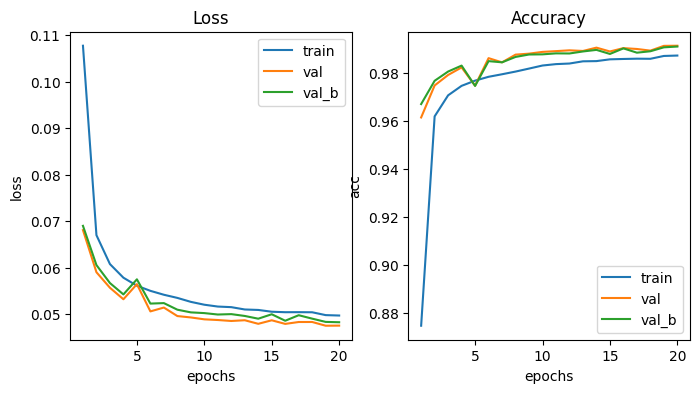

In [290]:
training_manager2.plot()

### CE

In [310]:
config = {
    'lr': 1e-4,
    'weight_decay': 1e-5,
    'k' : 10,
    'encoder_dropout_config' : {'skip_1': 0.0, 'skip_2': 0.0, 'skip_3': 0.0, 'skip_4': 0.5, 'skip_5': 0.5 },
    'decoder_dropout_config' : [0.5, 0, 0, 0]
}

training_manager3 = TrainingManager(dataloaders, config)

In [311]:
training_manager3.train(epochs=20, eval_mode='all')

  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 1
Loss: train = 0.3222, val = 0.1341
Acc: train = 89.9356, val = 96.1491
Bayes_validation: loss = 0.1328, acc = 96.8826


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 2
Loss: train = 0.1303, val = 0.0820
Acc: train = 96.3226, val = 97.6044
Bayes_validation: loss = 0.0857, acc = 97.7966


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 3
Loss: train = 0.0958, val = 0.0671
Acc: train = 97.1291, val = 97.9165
Bayes_validation: loss = 0.0676, acc = 98.1115


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 4
Loss: train = 0.0793, val = 0.0517
Acc: train = 97.5081, val = 98.2951
Bayes_validation: loss = 0.0548, acc = 98.3090


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 5
Loss: train = 0.0709, val = 0.0473
Acc: train = 97.6943, val = 98.4270
Bayes_validation: loss = 0.0554, acc = 98.1983


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 6
Loss: train = 0.0635, val = 0.0421
Acc: train = 97.8721, val = 98.5361
Bayes_validation: loss = 0.0434, acc = 98.5431


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 7
Loss: train = 0.0594, val = 0.0369
Acc: train = 97.9791, val = 98.7010
Bayes_validation: loss = 0.0418, acc = 98.5709


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 8
Loss: train = 0.0561, val = 0.0353
Acc: train = 98.0625, val = 98.7385
Bayes_validation: loss = 0.0432, acc = 98.5042


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 9
Loss: train = 0.0534, val = 0.0357
Acc: train = 98.1330, val = 98.7381
Bayes_validation: loss = 0.0388, acc = 98.6913


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 10
Loss: train = 0.0498, val = 0.0318
Acc: train = 98.2475, val = 98.8292
Bayes_validation: loss = 0.0362, acc = 98.7024


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 11
Loss: train = 0.0479, val = 0.0299
Acc: train = 98.3111, val = 98.8987
Bayes_validation: loss = 0.0332, acc = 98.8293


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 12
Loss: train = 0.0469, val = 0.0288
Acc: train = 98.3388, val = 98.9235
Bayes_validation: loss = 0.0309, acc = 98.8998


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 13
Loss: train = 0.0431, val = 0.0278
Acc: train = 98.4699, val = 98.9450
Bayes_validation: loss = 0.0299, acc = 98.9076


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 14
Loss: train = 0.0431, val = 0.0276
Acc: train = 98.4718, val = 98.9772
Bayes_validation: loss = 0.0299, acc = 98.9230


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 15
Loss: train = 0.0413, val = 0.0277
Acc: train = 98.5281, val = 98.9770
Bayes_validation: loss = 0.0313, acc = 98.8686


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 16
Loss: train = 0.0407, val = 0.0266
Acc: train = 98.5429, val = 99.0048
Bayes_validation: loss = 0.0287, acc = 98.9594


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 17
Loss: train = 0.0380, val = 0.0300
Acc: train = 98.6320, val = 98.9133
Bayes_validation: loss = 0.0343, acc = 98.8236


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 18
Loss: train = 0.0379, val = 0.0260
Acc: train = 98.6362, val = 99.0387
Bayes_validation: loss = 0.0282, acc = 98.9719


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 19
Loss: train = 0.0384, val = 0.0245
Acc: train = 98.6390, val = 99.0695
Bayes_validation: loss = 0.0273, acc = 98.9949


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 20
Loss: train = 0.0365, val = 0.0272
Acc: train = 98.6827, val = 98.9859
Bayes_validation: loss = 0.0283, acc = 98.9810


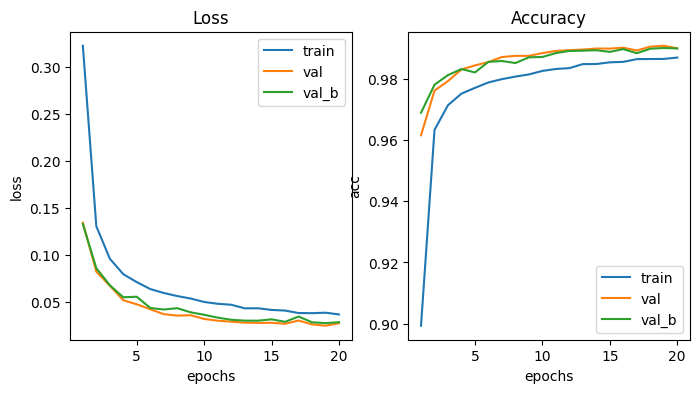

In [313]:
training_manager3.plot()

evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

5: 0.029053054749965668, 0.9896603226661682
10: 0.028473295271396637, 0.9897454380989075
15: 0.028093116357922554, 0.9899919629096985
20: 0.028082724660634995, 0.9898749589920044
25: 0.028281543403863907, 0.9897736310958862
30: 0.027711018919944763, 0.9900943040847778
35: 0.02787111885845661, 0.9900035858154297
40: 0.0276928823441267, 0.9900879263877869


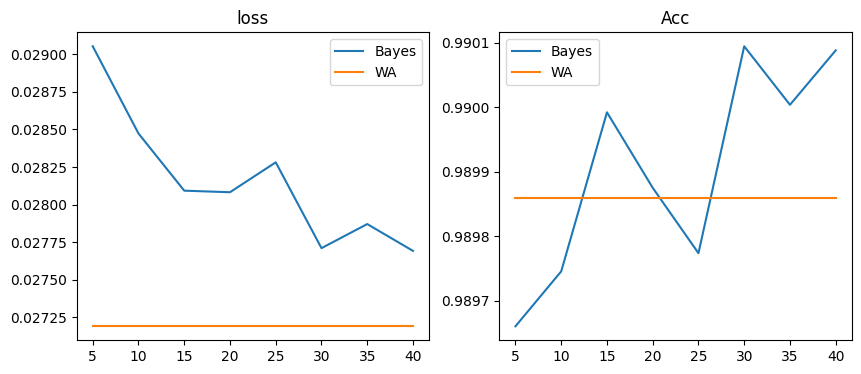

In [315]:
training_manager3.plot_acc_vs_k()

### More weight decay

In [317]:
config = {
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'k' : 10,
    'encoder_dropout_config' : {'skip_1': 0.0, 'skip_2': 0.0, 'skip_3': 0.0, 'skip_4': 0.5, 'skip_5': 0.5 },
    'decoder_dropout_config' : [0.5, 0, 0, 0]
}

training_manager4 = TrainingManager(dataloaders, config)

In [318]:
training_manager4.train(epochs=20, eval_mode='all')

  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 1
Loss: train = 0.3742, val = 0.1719
Acc: train = 88.1033, val = 95.4602
Bayes_validation: loss = 0.1577, acc = 96.7386


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 2
Loss: train = 0.1438, val = 0.0988
Acc: train = 96.3933, val = 97.3658
Bayes_validation: loss = 0.0985, acc = 97.7901


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 3
Loss: train = 0.1033, val = 0.0721
Acc: train = 97.1720, val = 98.0758
Bayes_validation: loss = 0.0778, acc = 98.1471


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 4
Loss: train = 0.0847, val = 0.0547
Acc: train = 97.4811, val = 98.3657
Bayes_validation: loss = 0.0598, acc = 98.3160


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 5
Loss: train = 0.0736, val = 0.0451
Acc: train = 97.6829, val = 98.5261
Bayes_validation: loss = 0.0526, acc = 98.3564


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 6
Loss: train = 0.0653, val = 0.0410
Acc: train = 97.8933, val = 98.6431
Bayes_validation: loss = 0.0452, acc = 98.5463


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 7
Loss: train = 0.0599, val = 0.0373
Acc: train = 98.0082, val = 98.7067
Bayes_validation: loss = 0.0410, acc = 98.6565


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 8
Loss: train = 0.0559, val = 0.0362
Acc: train = 98.1021, val = 98.7414
Bayes_validation: loss = 0.0396, acc = 98.6731


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 9
Loss: train = 0.0532, val = 0.0366
Acc: train = 98.1726, val = 98.6502
Bayes_validation: loss = 0.0372, acc = 98.6845


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 10
Loss: train = 0.0503, val = 0.0322
Acc: train = 98.2455, val = 98.8281
Bayes_validation: loss = 0.0367, acc = 98.7013


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 11
Loss: train = 0.0478, val = 0.0330
Acc: train = 98.3232, val = 98.7767
Bayes_validation: loss = 0.0385, acc = 98.6109


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 12
Loss: train = 0.0477, val = 0.0282
Acc: train = 98.3299, val = 98.9669
Bayes_validation: loss = 0.0307, acc = 98.9258


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 13
Loss: train = 0.0434, val = 0.0293
Acc: train = 98.4544, val = 98.9202
Bayes_validation: loss = 0.0313, acc = 98.8924


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 14
Loss: train = 0.0431, val = 0.0272
Acc: train = 98.4676, val = 98.9961
Bayes_validation: loss = 0.0301, acc = 98.9184


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 15
Loss: train = 0.0424, val = 0.0274
Acc: train = 98.4872, val = 98.9861
Bayes_validation: loss = 0.0303, acc = 98.9056


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 16
Loss: train = 0.0399, val = 0.0281
Acc: train = 98.5755, val = 98.9526
Bayes_validation: loss = 0.0296, acc = 98.9164


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 17
Loss: train = 0.0390, val = 0.0247
Acc: train = 98.6062, val = 99.0837
Bayes_validation: loss = 0.0275, acc = 98.9881


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 18
Loss: train = 0.0378, val = 0.0244
Acc: train = 98.6481, val = 99.0899
Bayes_validation: loss = 0.0273, acc = 99.0037


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 19
Loss: train = 0.0373, val = 0.0241
Acc: train = 98.6616, val = 99.0960
Bayes_validation: loss = 0.0263, acc = 99.0440


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 20
Loss: train = 0.0362, val = 0.0264
Acc: train = 98.6894, val = 99.0364
Bayes_validation: loss = 0.0296, acc = 98.9611


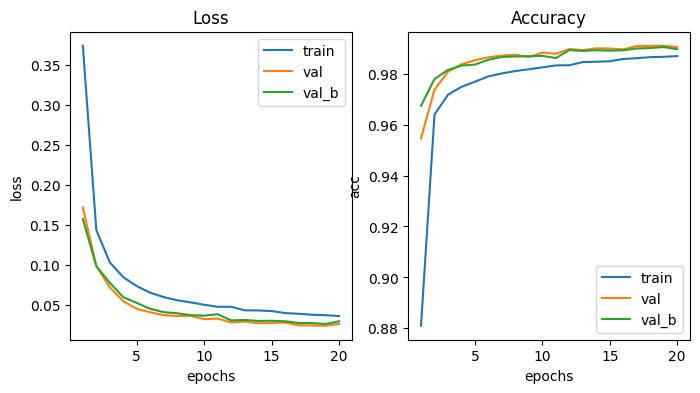

In [319]:
training_manager4.plot()

evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

5: 0.02987321838736534, 0.9895151257514954
10: 0.029045285657048225, 0.9897810816764832
15: 0.02896144613623619, 0.9899144768714905
20: 0.029085271060466766, 0.9898137450218201
25: 0.02890062890946865, 0.9899491667747498
30: 0.028981396928429604, 0.9897984266281128
35: 0.028880581259727478, 0.9899219274520874
40: 0.028877202421426773, 0.9898622035980225


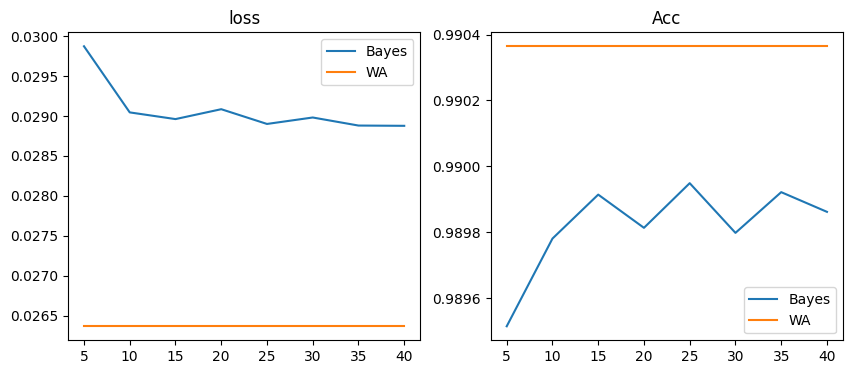

In [320]:
training_manager4.plot_acc_vs_k()

### Less dropout

In [325]:
config = {
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'k' : 10,
    'encoder_dropout_config' : {'skip_1': 0.0, 'skip_2': 0.0, 'skip_3': 0.0, 'skip_4': 0.0, 'skip_5': 0.5 },
    'decoder_dropout_config' : [0.5, 0, 0, 0]
}

training_manager5 = TrainingManager(dataloaders, config)

In [326]:
training_manager5.train(epochs=20, eval_mode='all')

  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 1
Loss: train = 0.3393, val = 0.1501
Acc: train = 89.3719, val = 95.9937
Bayes_validation: loss = 0.1457, acc = 96.8857


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 2
Loss: train = 0.1309, val = 0.0789
Acc: train = 96.5316, val = 97.8493
Bayes_validation: loss = 0.0862, acc = 97.9103


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 3
Loss: train = 0.0917, val = 0.0625
Acc: train = 97.4101, val = 98.1086
Bayes_validation: loss = 0.0640, acc = 98.2425


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 4
Loss: train = 0.0748, val = 0.0549
Acc: train = 97.7437, val = 98.3099
Bayes_validation: loss = 0.0566, acc = 98.3736


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 5
Loss: train = 0.0655, val = 0.0456
Acc: train = 97.9264, val = 98.4788
Bayes_validation: loss = 0.0490, acc = 98.4363


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 6
Loss: train = 0.0591, val = 0.0391
Acc: train = 98.0731, val = 98.6659
Bayes_validation: loss = 0.0411, acc = 98.6475


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 7
Loss: train = 0.0535, val = 0.0358
Acc: train = 98.2047, val = 98.7543
Bayes_validation: loss = 0.0391, acc = 98.6746


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 8
Loss: train = 0.0509, val = 0.0351
Acc: train = 98.2548, val = 98.7583
Bayes_validation: loss = 0.0399, acc = 98.6069


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 9
Loss: train = 0.0474, val = 0.0324
Acc: train = 98.3701, val = 98.8465
Bayes_validation: loss = 0.0361, acc = 98.7564


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 10
Loss: train = 0.0446, val = 0.0307
Acc: train = 98.4465, val = 98.8962
Bayes_validation: loss = 0.0329, acc = 98.8357


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 11
Loss: train = 0.0433, val = 0.0301
Acc: train = 98.4927, val = 98.9043
Bayes_validation: loss = 0.0338, acc = 98.8063


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 12
Loss: train = 0.0422, val = 0.0274
Acc: train = 98.5163, val = 98.9887
Bayes_validation: loss = 0.0300, acc = 98.9320


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 13
Loss: train = 0.0394, val = 0.0268
Acc: train = 98.6169, val = 99.0101
Bayes_validation: loss = 0.0283, acc = 98.9780


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 14
Loss: train = 0.0385, val = 0.0276
Acc: train = 98.6373, val = 98.9512
Bayes_validation: loss = 0.0289, acc = 98.9443


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 15
Loss: train = 0.0374, val = 0.0269
Acc: train = 98.6696, val = 99.0024
Bayes_validation: loss = 0.0286, acc = 98.9551


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 16
Loss: train = 0.0362, val = 0.0247
Acc: train = 98.7187, val = 99.0754
Bayes_validation: loss = 0.0259, acc = 99.0609


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 17
Loss: train = 0.0341, val = 0.0290
Acc: train = 98.7823, val = 98.9613
Bayes_validation: loss = 0.0324, acc = 98.8862


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 18
Loss: train = 0.0356, val = 0.0255
Acc: train = 98.7346, val = 99.0985
Bayes_validation: loss = 0.0272, acc = 99.0687


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 19
Loss: train = 0.0339, val = 0.0263
Acc: train = 98.7897, val = 99.0230
Bayes_validation: loss = 0.0285, acc = 98.9494


  0%|          | 0/123 [00:00<?, ?it/s]

Epoch 20
Loss: train = 0.0345, val = 0.0233
Acc: train = 98.7792, val = 99.1357
Bayes_validation: loss = 0.0248, acc = 99.0953


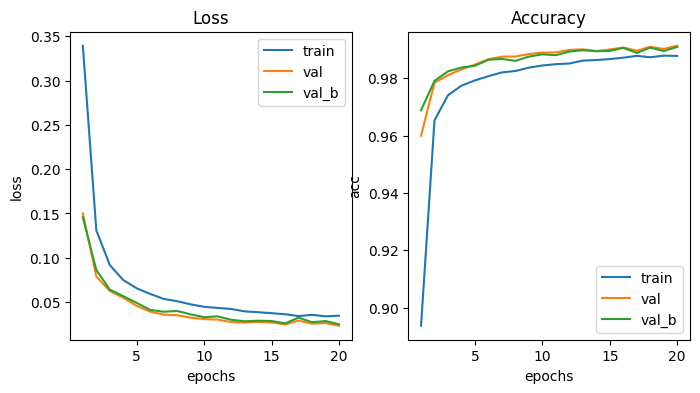

In [327]:
training_manager5.plot()

evaluating...


  0%|          | 0/8 [00:00<?, ?it/s]

5: 0.024946080520749092, 0.9909715056419373
10: 0.024706289172172546, 0.9910104274749756
15: 0.024882633239030838, 0.9909577965736389
20: 0.024747680872678757, 0.9910196661949158
25: 0.02481088973581791, 0.9909857511520386
30: 0.024597791954874992, 0.9910824298858643
35: 0.02447223663330078, 0.9911460876464844
40: 0.0247326847165823, 0.9910207390785217


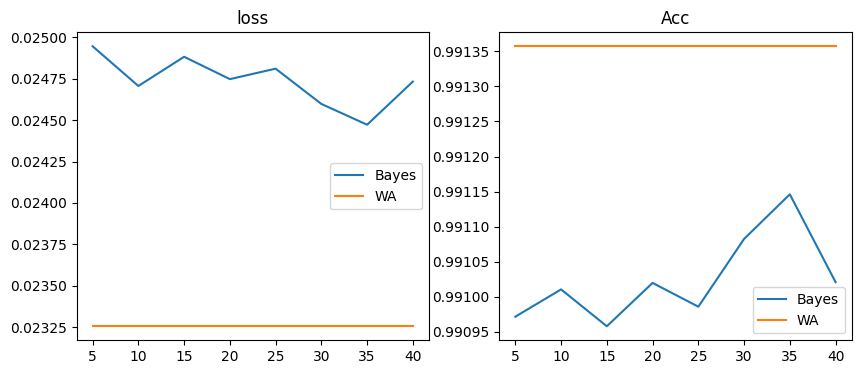

In [341]:
training_manager5.plot_acc_vs_k()

## Qualitative performance

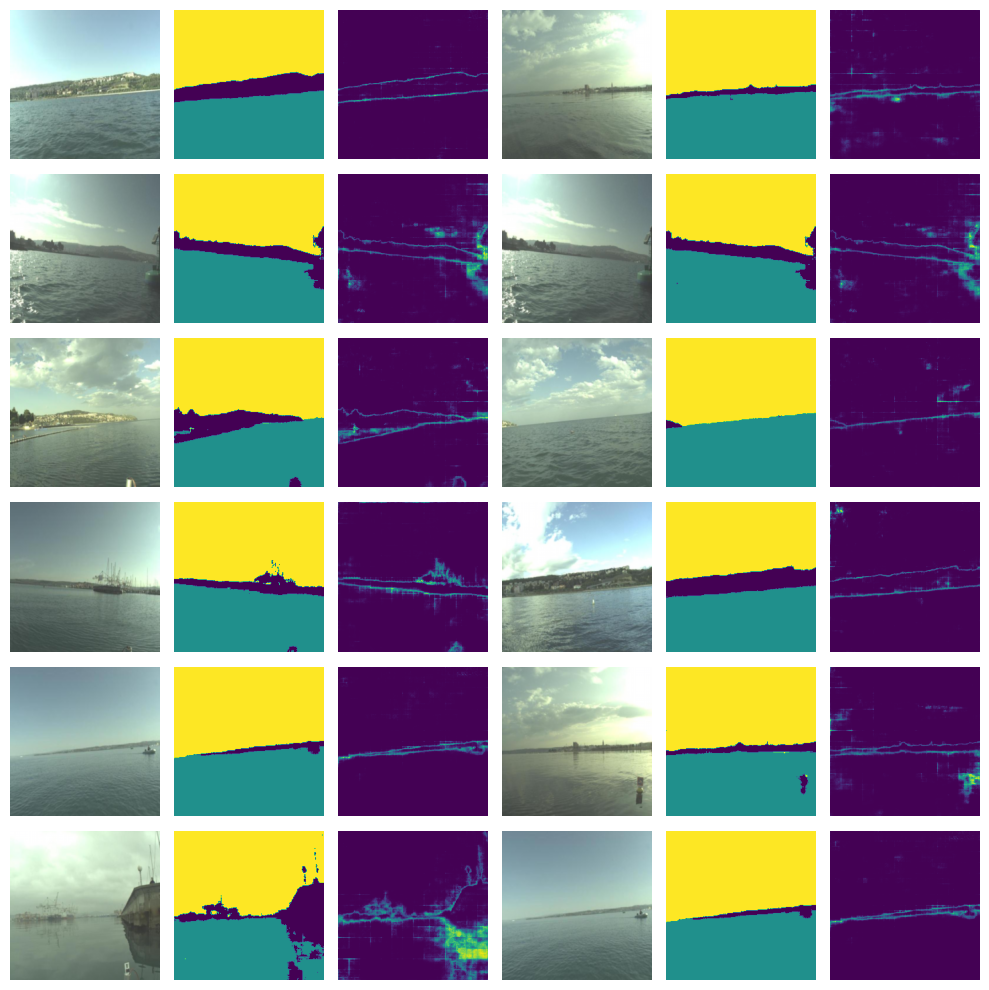

In [342]:
exp = training_manager5
plt.figure(figsize=(10, 10))

exp.net.toggle_dropout(True)
# exp.net.eval()

k = 20

for i in range(6):
  x, y = next(iter(dataloaders['val']))
  x, y = x[0], y[0]
  _, y_pred, _, y_std = bayes_forward(exp.net, x, k)
  plt.subplot(6, 6, i*6+1)
  plt.imshow(unnormalize(x).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+2)
  plt.imshow(y_pred.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+3)
  plt.imshow(y_std.cpu())
  plt.axis('off')

  x, y = next(iter(dataloaders['val']))
  x, y = x[0], y[0]
  _, y_pred, _, y_std = bayes_forward(exp.net, x, k)
  plt.subplot(6, 6, i*6+4)
  plt.imshow(unnormalize(x).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+5)
  plt.imshow(y_pred.cpu())
  plt.axis('off')

  plt.subplot(6, 6, i*6+6)
  plt.imshow(y_std.cpu())
  plt.axis('off')

plt.tight_layout()

In [334]:
y_std.max()

tensor(0.2667, device='cuda:0')